# PaDiM Baseline Training (Clean Domain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/05_padim_clean.ipynb)

**Phase 4: Baseline Model Implementation**

---

## PaDiM Method

**PaDiM** = Probabilistic Anomaly Detection with Multi-scale features

- Extracts multi-scale features from ResNet
- Models normal appearance using Gaussian distributions
- Uses Mahalanobis distance for anomaly scoring
- **No gradient-based training** (statistical approach)

---

## Setup - Mount Drive & Configure Paths

In [1]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository on main branch
print("Cloning repository (branch: main)...")
repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Set project root
PROJECT_ROOT = Path(repo_dir)
sys.path.insert(0, str(PROJECT_ROOT))
print(f"[OK] Path configured")

Mounting Google Drive...
Mounted at /content/drive
Done!

Cloning repository (branch: main)...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 528, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 528 (delta 14), reused 21 (delta 7), pack-reused 477 (from 1)
Receiving objects: 100% (528/528), 169.32 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (294/294), done.
Updating files: 100% (58/58), done.
Done!

[OK] Path configured


## Imports

In [2]:
# ============================================================
# INSTALL ANOMALIB - REQUIRED FOR PADIM
# ============================================================
# anomalib provides PaDiM's underlying implementation

print("Installing anomalib...")
!pip install anomalib --quiet

# Verify installation
try:
    import anomalib
    from anomalib.models.image.padim import Padim
    from anomalib.models.image.padim.torch_model import PadimModel
    print(f"Success! anomalib {anomalib.__version__} installed")
    print("PaDiM components available")
except ImportError as e:
    print(f"Error: {e}")
    print("Retry: !pip install anomalib")

Installing anomalib...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 66.6 MB/s eta 0:00:00
Success! anomalib 2.2.0 installed
PaDiM components available


## Install Dependencies

In [6]:
# ============================================================
# IMPORTS - All required modules
# ============================================================

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import json
import zipfile
from datetime import datetime

# Project imports
from src.models.padim_wrapper import PadimWrapper
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.utils.config import load_config
from src.data.splitter import load_splits
from src.utils.reproducibility import set_seed
from src.utils.paths import ProjectPaths

print("[OK] All modules imported successfully")

[OK] All modules imported successfully


## Configuration

In [7]:
# ============================================================
# CONFIGURATION - Load experiment config
# ============================================================

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Settings
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
NUM_WORKERS = 2
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Set seed for reproducibility
set_seed(config.seed)

print(f"\n[INFO] PaDiM Configuration:")
print(f"  Backbone: {config.padim.backbone}")
print(f"  Layers: {config.padim.layers}")
print(f"  Feature dimension: {config.padim.n_features}")
print(f"  Device: {DEVICE}")
print(f"  Classes: {CLASSES}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Random seed set to 42 for reproducibility

[INFO] PaDiM Configuration:
  Backbone: resnet50
  Layers: ['layer1', 'layer2', 'layer3']
  Feature dimension: 100
  Device: cuda
  Classes: ['hazelnut', 'carpet', 'zipper']


In [8]:
# Load clean splits
splits = load_splits(paths.get_split_path('clean'))

print("Dataset splits loaded:")
print("=" * 70)
for class_name in config.dataset.classes:
    print(f"\n{class_name.upper()}:")
    for split_name in ['train', 'val', 'test']:
        split_data = splits[class_name][split_name]
        n_normal = sum(1 for l in split_data['labels'] if l == 0)
        n_anomalous = sum(1 for l in split_data['labels'] if l == 1)
        print(f"  {split_name:5s}: {len(split_data['labels']):4d} images "
              f"({n_normal:3d} normal, {n_anomalous:3d} anomalous)")

Dataset splits loaded:

HAZELNUT:
  train:  312 images (312 normal,   0 anomalous)
  val  :  100 images ( 79 normal,  21 anomalous)
  test :   89 images ( 40 normal,  49 anomalous)

CARPET:
  train:  224 images (224 normal,   0 anomalous)
  val  :   82 images ( 56 normal,  26 anomalous)
  test :   91 images ( 28 normal,  63 anomalous)

ZIPPER:
  train:  192 images (192 normal,   0 anomalous)
  val  :   83 images ( 48 normal,  35 anomalous)
  test :  116 images ( 32 normal,  84 anomalous)


## Load Data

In [12]:
# Create transform (SAME AS PATCHCORE - same preprocessing for fair comparison)
transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

print(f"[OK] Transform initialized:")
print(f"  Size: {config.dataset.image_size}x{config.dataset.image_size}")
print(f"  Normalization: ImageNet statistics")
print(f"  Augmentation: None (deterministic preprocessing)")

# Custom collate function to handle None masks
def custom_collate_fn(batch):
    """Custom collate function that handles None masks."""
    images = torch.stack([item[0] for item in batch])
    masks = [item[1] for item in batch]  # Keep as list (may contain None)
    labels = torch.tensor([item[2] for item in batch])
    paths = [item[3] for item in batch]
    return images, masks, labels, paths

# Helper function to create DataLoader (ALIGNED WITH PATCHCORE)
def create_dataloader(split_dict, batch_size=32, shuffle=False):
    """Create DataLoader from split dict (same format as PatchCore)."""
    dataset = MVTecDataset(
        images=split_dict['images'],
        masks=split_dict['masks'],
        labels=split_dict['labels'],
        transform=transform,
        phase='train' if shuffle else 'val'
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True if DEVICE == 'cuda' else False,
        collate_fn=custom_collate_fn  # Use custom collate to handle None masks
    )

    return loader

print("[OK] DataLoader helper function ready")

[OK] Transform initialized:
  Size: 224x224
  Normalization: ImageNet statistics
  Augmentation: None (deterministic preprocessing)
[OK] DataLoader helper function ready


## Training Loop

In [13]:
# Initialize results tracking
MODEL_DIR = PROJECT_ROOT / 'outputs' / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

training_results = {
    'classes': [],
    'num_train_samples': [],
    'training_time_seconds': [],
    'memory_bank_size_mb': [],
    'model_path': []
}

trained_models = {}

print(f" Model directory: {MODEL_DIR}")

 Model directory: /content/Detection-of-Anomalies-with-Localization/outputs/models


In [14]:
# Train PaDiM for each class
print("\n" + "="*80)
print("[START] TRAINING PaDiM MODELS")
print("="*80 + "\n")

for class_name in CLASSES:
    print(f"\n{'='*80}")
    print(f"[TRAIN] PaDiM: {class_name.upper()}")
    print(f"{'='*80}\n")

    # 1. Load data (ALIGNED WITH PATCHCORE)
    split_data = splits[class_name]
    train_loader = create_dataloader(
        split_dict=split_data['train'],
        batch_size=BATCH_SIZE,
        shuffle=False  # No shuffle for deterministic training
    )

    print(f"[OK] Loaded {len(train_loader.dataset)} training samples\n")

    # 2. Initialize model
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )

    # 3. Train (fit on normal samples)
    model.fit(train_loader, verbose=True)

    # 4. Save
    model_path = MODEL_DIR / f"padim_{class_name}_clean.pt"
    model.save(model_path, include_stats=True)

    # 5. Store results
    training_results['classes'].append(class_name)
    training_results['num_train_samples'].append(model.training_stats['num_samples'])
    training_results['training_time_seconds'].append(model.training_stats['training_time_seconds'])
    training_results['memory_bank_size_mb'].append(model.training_stats['memory_bank_size_mb'])
    training_results['model_path'].append(str(model_path))

    trained_models[class_name] = model

    print(f"\n[COMPLETE] {class_name}")
    print(f"   Model: {model_path.name}")
    print(f"   Time: {model.training_stats['training_time_seconds']:.2f}s")

print(f"\n{'='*80}")
print("[SUCCESS] ALL CLASSES TRAINED SUCCESSFULLY!")
print(f"{'='*80}\n")


[START] TRAINING PaDiM MODELS


[TRAIN] PaDiM: HAZELNUT

[OK] Loaded 312 training samples


Training PaDiM on 312 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it]



Computing Gaussian distributions...
  Embedding shape: torch.Size([312, 100, 56, 56])
  Spatial resolution: 56x56

[OK] Training completed in 84.32s
  Memory bank size: 120.83 MB
  Gaussian distributions: 56x56 spatial locations

[OK] Model saved: padim_hazelnut_clean.pt
  Stats saved: padim_hazelnut_clean.json

[COMPLETE] hazelnut
   Model: padim_hazelnut_clean.pt
   Time: 84.32s

[TRAIN] PaDiM: CARPET

[OK] Loaded 224 training samples


Training PaDiM on 224 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 7/7 [01:51<00:00, 15.94s/it]



Computing Gaussian distributions...
  Embedding shape: torch.Size([224, 100, 56, 56])
  Spatial resolution: 56x56

[OK] Training completed in 111.80s
  Memory bank size: 120.83 MB
  Gaussian distributions: 56x56 spatial locations

[OK] Model saved: padim_carpet_clean.pt
  Stats saved: padim_carpet_clean.json

[COMPLETE] carpet
   Model: padim_carpet_clean.pt
   Time: 111.80s

[TRAIN] PaDiM: ZIPPER

[OK] Loaded 192 training samples


Training PaDiM on 192 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 6/6 [01:15<00:00, 12.59s/it]



Computing Gaussian distributions...
  Embedding shape: torch.Size([192, 100, 56, 56])
  Spatial resolution: 56x56

[OK] Training completed in 75.71s
  Memory bank size: 120.83 MB
  Gaussian distributions: 56x56 spatial locations

[OK] Model saved: padim_zipper_clean.pt
  Stats saved: padim_zipper_clean.json

[COMPLETE] zipper
   Model: padim_zipper_clean.pt
   Time: 75.71s

[SUCCESS] ALL CLASSES TRAINED SUCCESSFULLY!



## Training Results

In [15]:
# Save training results to JSON
results_path = PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_results_clean.json'
results_path.parent.mkdir(parents=True, exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(training_results, f, indent=2)

# Save as CSV for easy viewing
import pandas as pd
results_df = pd.DataFrame(training_results)
csv_path = PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_stats_clean.csv'
results_df.to_csv(csv_path, index=False)

print(f"\n[OK] Results saved: {results_path.name}")


[OK] Results saved: padim_training_results_clean.json


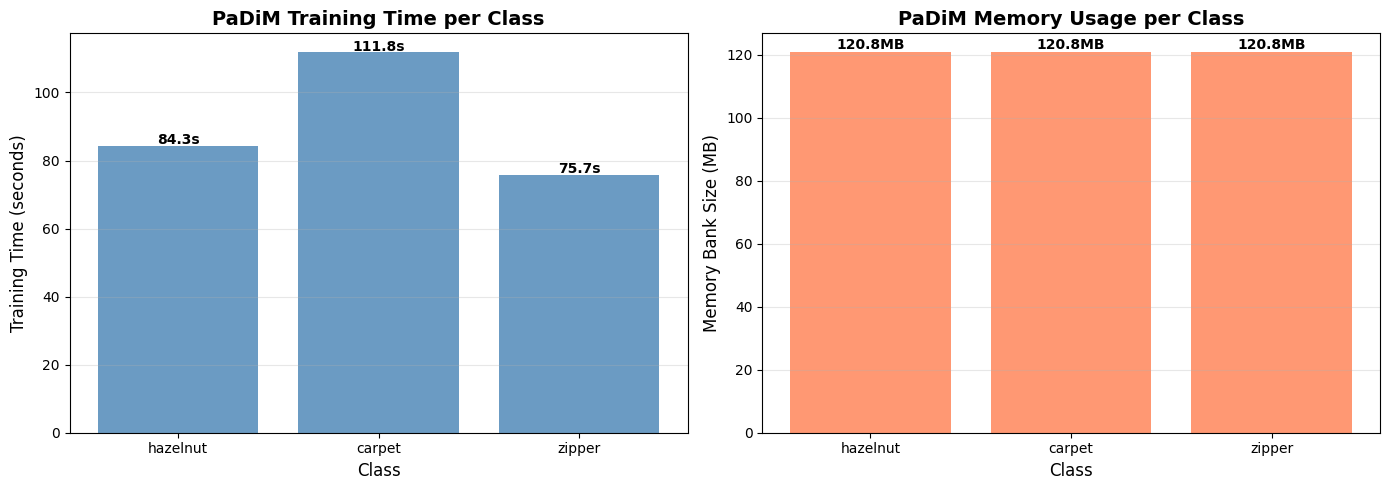

In [16]:
# Visualize training results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training time
axes[0].bar(results_df['classes'], results_df['training_time_seconds'], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Training Time (seconds)', fontsize=12)
axes[0].set_title('PaDiM Training Time per Class', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['training_time_seconds']):
    axes[0].text(i, v + 0.5, f"{v:.1f}s", ha='center', fontweight='bold')

# Memory bank size
axes[1].bar(results_df['classes'], results_df['memory_bank_size_mb'], color='coral', alpha=0.8)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Memory Bank Size (MB)', fontsize=12)
axes[1].set_title('PaDiM Memory Usage per Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['memory_bank_size_mb']):
    axes[1].text(i, v + 1, f"{v:.1f}MB", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Testing and Validation

Comprehensive tests to verify models work correctly

In [17]:
# TEST 1: Verify all models load correctly
print("="*80)
print("[TEST 1] Model Loading")
print("="*80 + "\n")

all_load_success = True
for class_name in CLASSES:
    model_path = MODEL_DIR / f"padim_{class_name}_clean.pt"
    try:
        test_model = PadimWrapper(device=DEVICE)
        test_model.load(model_path)
        print(f"[OK] {class_name}: Loaded successfully")
    except Exception as e:
        print(f"[FAIL] {class_name}: Failed - {e}")
        all_load_success = False

if all_load_success:
    print(f"\n{'='*80}")
    print("[PASS] TEST 1 PASSED: All models load correctly")
    print("="*80)
else:
    print(f"\n{'='*80}")
    print("[FAIL] TEST 1 FAILED: Some models failed to load")
    print("="*80)

[TEST 1] Model Loading

[OK] Model loaded: padim_hazelnut_clean.pt
[OK] hazelnut: Loaded successfully
[OK] Model loaded: padim_carpet_clean.pt
[OK] carpet: Loaded successfully
[OK] Model loaded: padim_zipper_clean.pt
[OK] zipper: Loaded successfully

[PASS] TEST 1 PASSED: All models load correctly


In [18]:
# TEST 2: Verify predictions work and anomalous > normal
print(f"\n\n{'='*80}")
print("[TEST 2] Prediction Validation")
print("="*80 + "\n")

test_results = []

for class_name in CLASSES:
    print(f"Testing {class_name}...")
    model = trained_models[class_name]
    split_data = splits[class_name]

    # Create val loader
    val_loader = create_dataloader(
        split_dict=split_data['val'],
        batch_size=1,
        shuffle=False
    )

    # Get one normal and one anomalous sample
    normal_score = None
    anomalous_score = None

    for images, masks, labels, paths in val_loader:
        label = labels.item()

        if label == 0 and normal_score is None:
            # Single image prediction
            score, _ = model.predict(images, return_heatmaps=False)
            normal_score = float(score)
        elif label == 1 and anomalous_score is None:
            score, _ = model.predict(images, return_heatmaps=False)
            anomalous_score = float(score)

        if normal_score is not None and anomalous_score is not None:
            break

    # Check result
    passed = anomalous_score > normal_score if (normal_score and anomalous_score) else False
    status = "[OK]" if passed else "[FAIL]"

    print(f"  {status} Normal score: {normal_score:.4f}")
    print(f"  {status} Anomalous score: {anomalous_score:.4f}")
    print(f"  {status} Test: {'PASSED' if passed else 'FAILED'}\n")

    test_results.append(passed)

if all(test_results):
    print(f"{'='*80}")
    print("[PASS] TEST 2 PASSED: Anomalous scores > Normal scores for all classes")
    print("="*80)
else:
    print(f"{'='*80}")
    print("[WARNING] TEST 2 WARNING: Some anomalous scores not higher than normal")
    print("="*80)



[TEST 2] Prediction Validation

Testing hazelnut...


/tmp/ipython-input-4227752945.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  normal_score = float(score)
/tmp/ipython-input-4227752945.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  anomalous_score = float(score)


  [OK] Normal score: 609.7409
  [OK] Anomalous score: 2278.7092
  [OK] Test: PASSED

Testing carpet...
  [OK] Normal score: 286.5226
  [OK] Anomalous score: 3814.5625
  [OK] Test: PASSED

Testing zipper...
  [OK] Normal score: 252.8311
  [OK] Anomalous score: 823.9855
  [OK] Test: PASSED

[PASS] TEST 2 PASSED: Anomalous scores > Normal scores for all classes




[TEST 3] Visual Validation

[OK] Predictions generated:
  Normal score: 609.7409
  Anomalous score: 2278.7092
  Global heatmap vmax: 2264.925



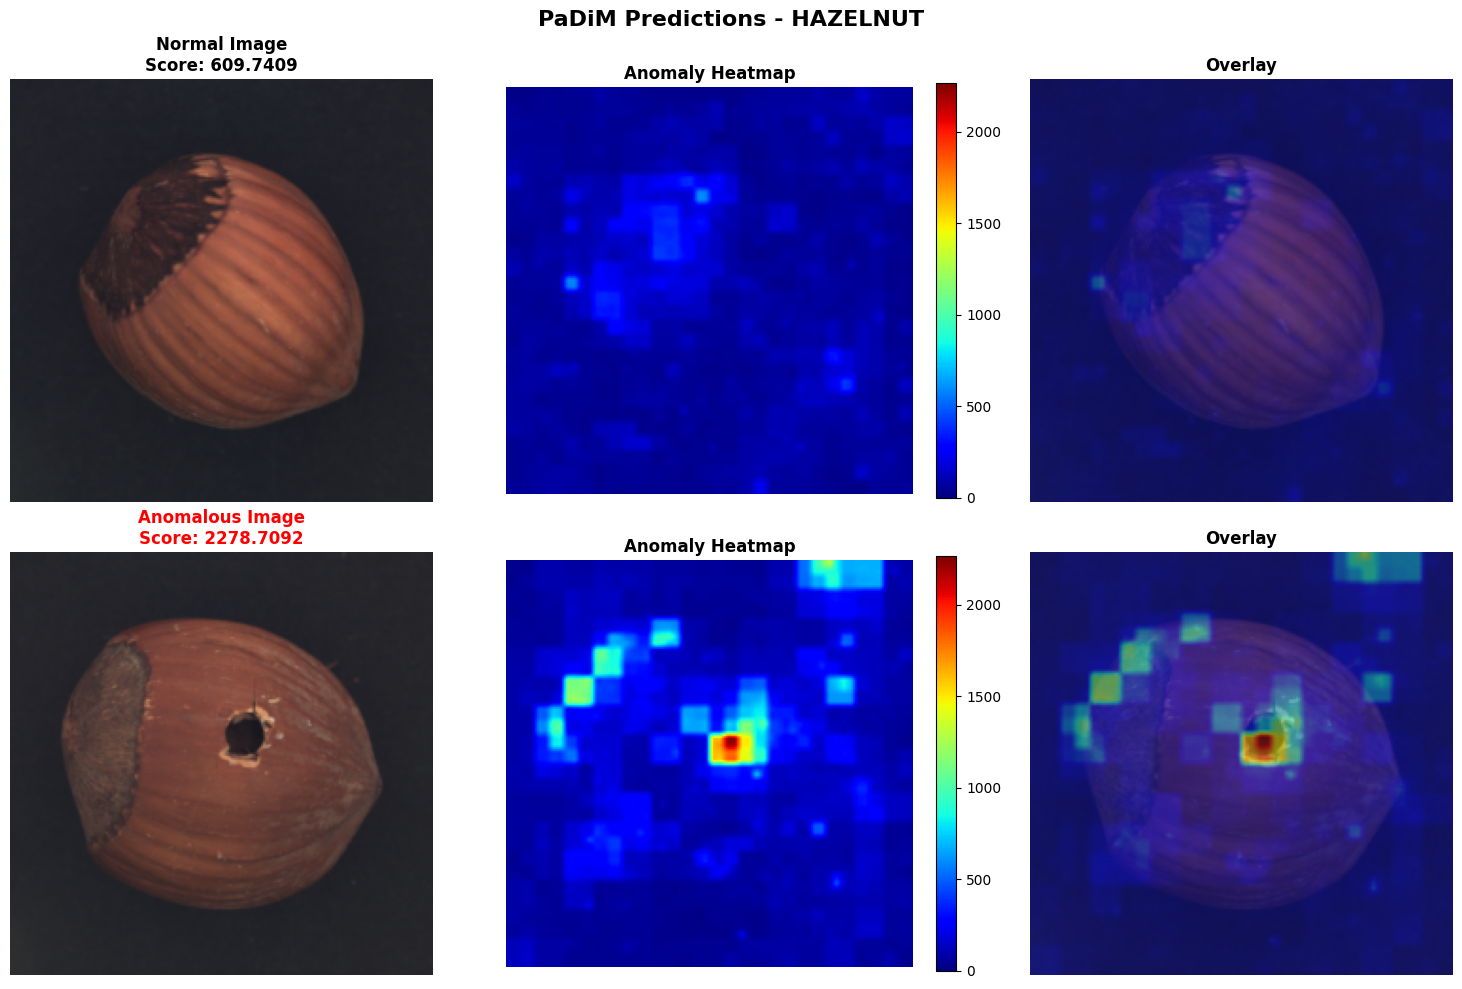

[PASS] TEST 3 PASSED: Visualizations generated successfully


In [21]:
# TEST 3: Visual validation
print(f"\n\n{'='*80}")
print("[TEST 3] Visual Validation")
print("="*80 + "\n")

# Select one class for visualization
TEST_CLASS = CLASSES[0]
model = trained_models[TEST_CLASS]
split_data = splits[TEST_CLASS]

# Create val loader
val_loader = create_dataloader(
    split_dict=split_data['val'],
    batch_size=1,
    shuffle=False
)

# Get one normal and one anomalous sample
normal_images = None
anomalous_images = None

for images, masks, labels, paths in val_loader:
    if labels.item() == 0 and normal_images is None:
        normal_images = images
    elif labels.item() == 1 and anomalous_images is None:
        anomalous_images = images

    if normal_images is not None and anomalous_images is not None:
        break

# Predict
normal_score, normal_heatmap = model.predict(normal_images, return_heatmaps=True)
anomalous_score, anomalous_heatmap = model.predict(anomalous_images, return_heatmaps=True)

# Handle scalar vs array
if isinstance(normal_score, np.ndarray):
    normal_score = normal_score.item()
if isinstance(anomalous_score, np.ndarray):
    anomalous_score = anomalous_score.item()

# Squeeze heatmaps to remove batch dimension (1, H, W) -> (H, W)
if normal_heatmap is not None and normal_heatmap.ndim == 3:
    normal_heatmap = normal_heatmap.squeeze(0)
if anomalous_heatmap is not None and anomalous_heatmap.ndim == 3:
    anomalous_heatmap = anomalous_heatmap.squeeze(0)

# Calculate global vmax for consistent heatmap scaling (ALIGNED WITH NOTEBOOK 04)
vmax_global = np.max([normal_heatmap.max(), anomalous_heatmap.max()])

print(f"[OK] Predictions generated:")
print(f"  Normal score: {normal_score:.4f}")
print(f"  Anomalous score: {anomalous_score:.4f}")
print(f"  Global heatmap vmax: {vmax_global:.3f}\n")

# Denormalize for visualization (SAME AS NOTEBOOK 04)
def denormalize_image(img_tensor, mean, std):
    """Denormalize image for visualization."""
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(img, 0, 1)

mean = config.dataset.normalize.mean
std = config.dataset.normalize.std

normal_img = denormalize_image(normal_images[0].cpu(), mean, std)
normal_img = normal_img.permute(1, 2, 0).numpy()

anomalous_img = denormalize_image(anomalous_images[0].cpu(), mean, std)
anomalous_img = anomalous_img.permute(1, 2, 0).numpy()

# Plot (ALIGNED WITH NOTEBOOK 04 STYLE)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Normal sample
axes[0, 0].imshow(normal_img)
axes[0, 0].set_title(f'Normal Image\nScore: {normal_score:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

im1 = axes[0, 1].imshow(normal_heatmap, cmap='jet', vmin=0, vmax=vmax_global)
axes[0, 1].set_title('Anomaly Heatmap', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

axes[0, 2].imshow(normal_img)
axes[0, 2].imshow(normal_heatmap, cmap='jet', alpha=0.5, vmin=0, vmax=vmax_global)
axes[0, 2].set_title('Overlay', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Anomalous sample
axes[1, 0].imshow(anomalous_img)
axes[1, 0].set_title(f'Anomalous Image\nScore: {anomalous_score:.4f}', fontsize=12, fontweight='bold', color='red')
axes[1, 0].axis('off')

im2 = axes[1, 1].imshow(anomalous_heatmap, cmap='jet', vmin=0, vmax=vmax_global)
axes[1, 1].set_title('Anomaly Heatmap', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)

axes[1, 2].imshow(anomalous_img)
axes[1, 2].imshow(anomalous_heatmap, cmap='jet', alpha=0.5, vmin=0, vmax=vmax_global)
axes[1, 2].set_title('Overlay', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.suptitle(f'PaDiM Predictions - {TEST_CLASS.upper()}', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"{'='*80}")
print("[PASS] TEST 3 PASSED: Visualizations generated successfully")
print("="*80)

## Download Results

Create a ZIP package with all outputs for download

In [22]:
from google.colab import files

print("="*80)
print("[PACKAGE] Preparing Download Package")
print("="*80 + "\n")

# Create ZIP
zip_path = PROJECT_ROOT / 'padim_outputs.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add models
    for class_name in CLASSES:
        model_file = MODEL_DIR / f"padim_{class_name}_clean.pt"
        stats_file = MODEL_DIR / f"padim_{class_name}_clean.json"

        if model_file.exists():
            zipf.write(model_file, f"models/{model_file.name}")
            print(f"[OK] Added: {model_file.name}")

        if stats_file.exists():
            zipf.write(stats_file, f"models/{stats_file.name}")
            print(f"[OK] Added: {stats_file.name}")

    # Add results JSON
    if results_path.exists():
        zipf.write(results_path, f"results/{results_path.name}")
        print(f"[OK] Added: {results_path.name}")

print(f"\n[OK] Package created: {zip_path.name}")
print(f"   Size: {zip_path.stat().st_size / (1024**2):.2f} MB")

# Download
print(f"\n{'='*80}")
print("[DOWNLOAD] Starting download...")
print("="*80)
files.download(str(zip_path))
print("\n[OK] Download complete!")

[PACKAGE] Preparing Download Package

[OK] Added: padim_hazelnut_clean.pt
[OK] Added: padim_hazelnut_clean.json
[OK] Added: padim_carpet_clean.pt
[OK] Added: padim_carpet_clean.json
[OK] Added: padim_zipper_clean.pt
[OK] Added: padim_zipper_clean.json
[OK] Added: padim_training_results_clean.json

[OK] Package created: padim_outputs.zip
   Size: 396.29 MB

[DOWNLOAD] Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[OK] Download complete!


## Save to Google Drive

Copy all outputs to Google Drive for persistent storage

In [23]:
import shutil

# Create output directory in Google Drive
DRIVE_OUTPUT = Path('/content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs')
DRIVE_OUTPUT.mkdir(parents=True, exist_ok=True)

print("="*70)
print("[SAVE] Copying outputs to Google Drive...")
print("="*70 + "\n")

# 1. Copy model files
models_saved = []
for class_name in CLASSES:
    model_file = MODEL_DIR / f"padim_{class_name}_clean.pt"
    stats_file = MODEL_DIR / f"padim_{class_name}_clean.json"

    if model_file.exists():
        shutil.copy2(model_file, DRIVE_OUTPUT / model_file.name)
        models_saved.append(model_file.name)
        print(f"[OK] Saved: {model_file.name}")

    if stats_file.exists():
        shutil.copy2(stats_file, DRIVE_OUTPUT / stats_file.name)
        print(f"[OK] Saved: {stats_file.name}")

# 2. Copy results files
results_files = [
    (PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_stats_clean.csv', 'padim_training_stats_clean.csv'),
    (PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_results_clean.json', 'padim_training_results_clean.json')
]

for src, dst_name in results_files:
    if src.exists():
        shutil.copy2(src, DRIVE_OUTPUT / dst_name)
        print(f"[OK] Saved: {dst_name}")

print("\n" + "="*70)
print("[SUCCESS] OUTPUTS SAVED TO GOOGLE DRIVE!")
print("="*70)
print(f"Location: {DRIVE_OUTPUT}")
print(f"Total files: {len(list(DRIVE_OUTPUT.iterdir()))}")
print(f"Total size: {sum(f.stat().st_size for f in DRIVE_OUTPUT.iterdir() if f.is_file()) / (1024*1024):.2f} MB")
print("="*70)

[SAVE] Copying outputs to Google Drive...

[OK] Saved: padim_hazelnut_clean.pt
[OK] Saved: padim_hazelnut_clean.json
[OK] Saved: padim_carpet_clean.pt
[OK] Saved: padim_carpet_clean.json
[OK] Saved: padim_zipper_clean.pt
[OK] Saved: padim_zipper_clean.json
[OK] Saved: padim_training_stats_clean.csv
[OK] Saved: padim_training_results_clean.json

[SUCCESS] OUTPUTS SAVED TO GOOGLE DRIVE!
Location: /content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs
Total files: 8
Total size: 721.37 MB


---
### Outputs

```
outputs/models/
├── padim_hazelnut_clean.pt      (~50-100 MB each)
├── padim_hazelnut_clean.json
├── padim_carpet_clean.pt
├── padim_carpet_clean.json
├── padim_zipper_clean.pt
└── padim_zipper_clean.json

outputs/results/
└── padim_training_results_clean.json
```

